# Credmark - Uniswap V3 Liquidity Explorer

- 2022.7.29


In [1]:
from decimal import Decimal
import math

from src.sqrtmath import SqrtPriceMath
from src.v3_liquidity import *

smath = SqrtPriceMath()

In [2]:
%reload_ext credmark.cmf.ipython

from models.tmp_abi_lookup import UNISWAP_V3_POOL_ABI

cmf_param = {
    'chain_id': 1,
    'block_number': None,
    # 'chain_to_provider_url': {'1': 'https://mainnet.infura.io/v3/... or https://eth-mainnet.g.alchemy.com/'},
    'api_url': None,
    'use_local_models': None,
    'register_utility_global': True}

context, model_loader = %cmf cmf_param

In [3]:
def load_univ3_pool(_pool_addr):
    return Contract(address=_pool_addr).set_abi(UNISWAP_V3_POOL_ABI, set_loaded=True)

### Load from Ledger or file


In [4]:
load_from_ledger = False

if load_from_ledger:
    pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

    with pool.ledger.events.Flash as q:
        df_flash = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER,
                        limit=5000).to_dataframe()

    with pool.ledger.events.Mint as q:
        df_mint = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        where=q.EVT_BLOCK_NUMBER.le(12384601)
                        ).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        where=q.EVT_BLOCK_NUMBER.le(12384601)).to_dataframe()

    with pool.ledger.events.Swap as q:
        df_swap = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        where=q.EVT_BLOCK_NUMBER.le(12384601)).to_dataframe()

    df_flash.to_csv('csv/uni_flash.csv', index=False)
    df_mint.to_csv('csv/uni_mint.csv', index=False)
    df_burn.to_csv('csv/uni_burn.csv', index=False)
    df_swap.to_csv('csv/uni_swap.csv', index=False)

    with pool.ledger.events.Mint as q:
        df_mint_min_max = q.select(aggregates=[(q.TICKLOWER.min_(), 'lower_min'),
                                               (q.TICKUPPER.max_(), 'upper_max'),
                                               (q.EVT_BLOCK_NUMBER.min_(), 'block_number_min'),
                                               (q.EVT_BLOCK_NUMBER.max_(), 'block_number_max')]
                                ).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn_min_max = q.select(aggregates=[(q.TICKLOWER.min_(), 'lower_min'),
                                               (q.TICKUPPER.max_(), 'upper_max'),
                                               (q.EVT_BLOCK_NUMBER.min_(), 'block_number_min'),
                                               (q.EVT_BLOCK_NUMBER.max_(), 'block_number_max')]
                                ).to_dataframe()   

    df_mint_min_max.to_csv('csv/df_mint_min_max.csv', index=False)
    df_burn_min_max.to_csv('csv/df_burn_min_max.csv', index=False)
else:
    df_flash = pd.read_csv('csv/uni_flash.csv')
    df_mint = pd.read_csv('csv/uni_mint.csv')
    df_burn = pd.read_csv('csv/uni_burn.csv')
    df_swap = pd.read_csv('csv/uni_swap.csv')

    df_mint_min_max = pd.read_csv('csv/df_mint_min_max.csv')
    df_burn_min_max = pd.read_csv('csv/df_burn_min_max.csv')    

## Transform


1. Mint/Burn may not change liquidity, such as when amount = 0 (there could be more)
2. Swap may change the liquidity


In [5]:
@Model.describe(
    slug='jit.liquidity',
    version='1.0',
    output=dict)
class JitLiquidity(Model):
    def run(self, input):
        pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
        current_liquidity = pool.functions.liquidity().call()
        slot0 = pool.functions.slot0().call()
        current_tick = slot0[1]
        token0_addr = pool.functions.token0().call()
        token1_addr = pool.functions.token1().call()
        token0 = Token(address=Address(token0_addr).checksum)
        token1 = Token(address=Address(token1_addr).checksum)
        token0_bal = token0.balance_of(pool.address.checksum)
        token1_bal = token1.balance_of(pool.address.checksum)
        return {'liquidity': current_liquidity, 'tick': current_tick, 'token0_bal': token0_bal, 'token1_bal': token1_bal}

context.remove_model_by_slug('jit.liquidity')
context.add_model(JitLiquidity)

# Check whether the model has been loaded
assert 'jit.liquidity' in model_loader.loaded_model_version_lists()

In [6]:
df_mint_sel = (df_mint
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_tickLower', 'inp_tickUpper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
    .assign(inp_amount1 = lambda x: x.inp_amount1.apply(int))
)
df_mint_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563
1,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531
2,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,447994594415865,598469729,2599999995846641821
3,12377308,355,0x5f066eb8fefba0d1b491ffb924b708dc24158192a77f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660,194990,3508224747038658,3405610348,0
4,12377327,105,0x5184d8d442ac1696e9f7fb89c31db8c1de8ae9c80f3e...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640,194660,35118767990408024,1549658850,151652526935341123
5,12377429,37,0x112f8d32c821a10d91d333738b7b5f5db8ce19ed7c7d...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,4828391768114933,22181745033,4999999999799242017
6,12377645,294,0xa0ef29c71238e5d91bf4427b242c860e5cfd89d75d2a...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,200310,1092382261109467,15454577376,1282710509619309034
7,12378038,326,0x6e310ed13ea72d30bff67a919754c027cec654a174c8...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194750,194790,1499570648517615,167201379,2790710881979345
8,12378075,156,0x16321f1e501c0411c2d26bfc6c6e40fcaf5ac8f4f6e9...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,-46050,414490,3068914230032,181389532,51921516403623349
9,12378260,211,0x8fc80d2d648112f340b42f1e76c3ce7f52b6c61f10f7...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194720,194840,38466559516912,10000000,1033365407263396


In [7]:
df_burn_sel = (df_burn
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_tickLower', 'inp_tickUpper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
    .assign(inp_amount=lambda x: -x.inp_amount,
            inp_amount0=lambda x: -x.inp_amount0,
            inp_amount1=lambda x: -x.inp_amount1)
)
df_burn_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1
0,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373906
1,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0
2,12378139,281,0x0071c57b5c72215b9eb61237306078b0d66bc4b7477f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194750,194790,-1499570648517615,0,-50832403254742608
3,12378381,185,0x65604668f6fdfbccbeb35a21f007bebf6818132da39f...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194660,194990,-3508224747038658,-2196096821,-345697133216421583
4,12378701,400,0x70e43fee246eb5820c625627aecde047c8b3296297ed...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,276320,276330,-2000197335909935,-999999,0
5,12378975,305,0x52aedef3b34b14b0af2f63b205bc61fde5e529aee2d9...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194640,194660,-35118767990408024,0,-591666931208717492
6,12379404,384,0x641cf4b2131515ee408e2b869660627023793f877ccb...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,223340,230270,-96598418924930,-399999999,0
7,12381171,330,0xe59121c20bca00ca943ba2ce7b714e4d0a05aaece498...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,-447994594415865,-844518248,-2528365289342729024
8,12384559,158,0x26bbb0f5eec5930ab9b5319e4c02a6caeb257ff219e7...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198680,-34146802946959,-339483650,-101110504989477685
9,12384601,25,0x34a244f676e553b5eca4655ab5e3331fb8e2ca27b842...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,-4828391768114933,-18329786827,-6108217281320156656


In [8]:
df_swap.dtypes

contract_address    object
evt_block_number     int64
evt_tx_hash         object
evt_index            int64
inp_sender          object
inp_recipient       object
inp_amount0          int64
inp_amount1          int64
inp_sqrtPriceX96    object
inp_liquidity        int64
inp_tick             int64
dtype: object

In [9]:
(df_swap
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_recipient', 'inp_liquidity', 'inp_amount0', 'inp_amount1', 'inp_tick', 'inp_sqrtPriceX96']]
    .assign(inp_amount1 = lambda x: x.inp_amount1.apply(int),
            inp_sqrtPriceX96_d = lambda x: x.inp_sqrtPriceX96.apply(int))
    .assign(price = lambda x: x.inp_sqrtPriceX96_d * x.inp_sqrtPriceX96_d / (2 ** 192),
            price_tick = lambda x: (1.0001 ** x.inp_tick).apply(int),
            price_sqrt = lambda x: (1.0001 ** (x.inp_tick / 2) * (2 ** 96)).apply(int))
)

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick,inp_sqrtPriceX96,inp_sqrtPriceX96_d,price,price_tick,price_sqrt
0,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,-119744094,35000000000000000,194996,1358206768703179146794161129278934,1358206768703179146794161129278934,293881747.391735,293863251,1358164026850984271828621602062336
1,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,499756414,-144241064315415179,194645,1334545912983135722438993170925379,1334545912983135722438993170925379,283731707.552176,283728070,1334537359885312233470678878126080
2,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,365000000,-103492428467657963,194641,1334315597745343730478188229716159,1334315597745343730478188229716159,283633783.462463,283614607,1334270492444118574642620142714880
3,12377364,353,0x121c9e49d7a44eaa01e50070df2e4d8a95aace62ddfe...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,-176180828,50000000000000000,194643,1334426813649531849390742241713392,1334426813649531849390742241713392,283681067.481878,283671333,1334403919493362931880428123979776
4,12377369,133,0x26fd434e17ef8607ba00e09292232ebf45687c95603d...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,-514279985,146000000000000000,194648,1334751564089761156615399956745312,1334751564089761156615399956745312,283819159.373608,283813197,1334737545493726829507376574365696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,12384592,50,0x8ecb5547670c48d859fe79ee625b164775f3e8dc6d39...,0xc4580c566202F5343883D0c6a378a9de245C9399,62588669261808981,-2262599267,661319693401825231,194943,1354587491879879110759166522559356,1354587491879879110759166522559356,292317593.454519,292309973,1354569836292097836534713234227200
1018,12384597,130,0x56f15c5286cb3c59aedf453462647c1324698c5e0c32...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,4800000000,-1400587337321884656,194917,1352814551785681111381557099424019,1352814551785681111381557099424019,291552899.518261,291550992,1352810127547386461706475997757440
1019,12384598,310,0xbd2d98bbc989acc9c4b89ab1230f4fd2dc8db13b5a39...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,-904784090,263989549240969000,194922,1353148557116876612898815867605586,1353148557116876612898815867605586,291696884.137675,291696797,1353148355444885869553132681297920
1020,12384600,288,0xeb98c745b67049b384e0b1a2535d9a3abe7ee66a29c6...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,471797350,-137535307997831980,194919,1352974457397837680119589189448723,1352974457397837680119589189448723,291621827.961055,291609305,1352945408560141164035619250241536


In [10]:
df_swap_sel = (
    df_swap
        [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_recipient', 'inp_liquidity', 'inp_amount0', 'inp_amount1', 'inp_tick']]
        .assign(inp_amount1 = lambda x: x.inp_amount1.apply(int))
        .sort_values(['evt_block_number', 'evt_index'])
        .reset_index(drop=True)
)

# add inp_amount as the impact to laddressiquidity from Swaps (summed up per block)
df_swap_sel = df_swap_sel.assign(inp_amount=int(0))

evt_block_number = None
for n,r in df_swap_sel.iterrows():
    tick_info = context.models(r.evt_block_number-1).jit.liquidity()
    liquidity_diff_block = r.inp_liquidity - tick_info['liquidity']

    if evt_block_number is None or evt_block_number != r.evt_block_number:
        evt_block_number = r.evt_block_number 
        df_swap_sel.loc[n, 'inp_amount'] = liquidity_diff_block
    else:
        if liquidity_diff_block == df_swap_sel.loc[n-1, 'inp_amount']:
            df_swap_sel.loc[n, 'inp_amount'] = 0
        else:
            df_swap_sel.loc[n, 'inp_amount'] = r.inp_liquidity - tick_info['liquidity']
df_swap_sel

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick,inp_amount
0,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,-119744094,35000000000000000,194996,0
1,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,499756414,-144241064315415179,194645,-25652705721581
2,12377345,133,0x730978754a9a3db693148ac99b5d807555b2e7c1d664...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,365000000,-103492428467657963,194641,0
3,12377364,353,0x121c9e49d7a44eaa01e50070df2e4d8a95aace62ddfe...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,-176180828,50000000000000000,194643,0
4,12377369,133,0x26fd434e17ef8607ba00e09292232ebf45687c95603d...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,-514279985,146000000000000000,194648,0
...,...,...,...,...,...,...,...,...,...
1017,12384592,50,0x8ecb5547670c48d859fe79ee625b164775f3e8dc6d39...,0xc4580c566202F5343883D0c6a378a9de245C9399,62588669261808981,-2262599267,661319693401825231,194943,0
1018,12384597,130,0x56f15c5286cb3c59aedf453462647c1324698c5e0c32...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,4800000000,-1400587337321884656,194917,0
1019,12384598,310,0xbd2d98bbc989acc9c4b89ab1230f4fd2dc8db13b5a39...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,-904784090,263989549240969000,194922,0
1020,12384600,288,0xeb98c745b67049b384e0b1a2535d9a3abe7ee66a29c6...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62588669261808981,471797350,-137535307997831980,194919,0


In [11]:
# swaps that increases the liquidity
df_swap_sel.loc[df_swap_sel.inp_amount > 0, :]

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick,inp_amount
6,12377404,113,0x6d9dcc2254fcc904bb6966956aba709454e7b9937fb4...,0xE592427A0AEce92De3Edee1F18E0157C05861564,35601269895293825,925233824,-263498461658450219,194658,31610543243369366
10,12377475,259,0x2988e90d2f08ba706fad85b0936be746f5f2704d0bb3...,0xE592427A0AEce92De3Edee1F18E0157C05861564,40429661663408758,-1763491355,500000000000000000,194648,35118767990408024
13,12377505,116,0x6d5ce42064a4fb9b5daa6e28974338bc87bf513d7532...,0xCcA73b3D5Abaa49c656753E789A4ae880d906f98,40429661663408758,-2000000000,567418527790587421,194651,35118767990408024
60,12378126,231,0x6a51b774140af939644d60c6fee28272147029e9626b...,0xE592427A0AEce92De3Edee1F18E0157C05861564,11414140243896506,-696493247,200000000000000000,194770,1499570648517615
76,12378430,169,0xfa0fbc732958b1c6cc65087afc0891e82f423b0dac14...,0xcAdA38b3D2e3d8714E783ae8C420B4024817E3E8,6459500179192658,-1740427891,500000000000000000,194810,38466559516912
...,...,...,...,...,...,...,...,...,...
963,12384292,209,0x32e889ac50321aeeb7b95abcfba16026be5c7a121a9f...,0xE592427A0AEce92De3Edee1F18E0157C05861564,68047172598720294,4908810728,-1413845810722370566,194787,1433017637853446
975,12384338,191,0x54d3766583f0c3632efe357bdd9ed35566b5ab014874...,0xE592427A0AEce92De3Edee1F18E0157C05861564,68047172598720294,2714130118,-781791265042210236,194794,1433017637853446
991,12384414,234,0xdbf85817e4ed71db01e21fc752e8f9b22ece98f5261f...,0x2efeC2097beede290B2eED63e2FAf5ECbBC528FC,68047172598720294,5809237566,-1673897174921749832,194789,1433017637853446
994,12384438,35,0x2e4ebfd785e2c285931e42025f2ec10d10301e4bf2fa...,0xE592427A0AEce92De3Edee1F18E0157C05861564,66614154960866848,400000000,-115560309382282022,194829,14688771335513


In [12]:
# swaps that descreases the liquidity
df_swap_sel.loc[df_swap_sel.inp_amount < 0, :]

,evt_block_number,evt_index,evt_tx_hash,inp_recipient,inp_liquidity,inp_amount0,inp_amount1,inp_tick,inp_amount
1,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,499756414,-144241064315415179,194645,-25652705721581
5,12377375,573,0x27c122c4e26c3051d3741fa7350cccfca8064e4b7a8e...,0xE592427A0AEce92De3Edee1F18E0157C05861564,3990726651924459,-2020724832,575000000000000000,194725,-31610543243369366
9,12377468,278,0x5dada9d01fa209590ac2515401dac83c632688489697...,0xE592427A0AEce92De3Edee1F18E0157C05861564,5310893673000734,1985387610,-562454951913713500,194593,-35118767990408024
12,12377486,141,0x58e71afad7a07de6eb7ef23c7b4cbe65e75a052cb348...,0xE592427A0AEce92De3Edee1F18E0157C05861564,5310893673000734,2000000000,-566850891386685789,194604,-35118767990408024
14,12377530,287,0xd46f2c251a61561f2120d24f8a63cfba9e703b00ce94...,0x01F2C533bdB0e09eBFAeB85ac295c3b4D00Feffe,8819118420039392,-3868954138,1104441928932683385,194771,-31610543243369366
...,...,...,...,...,...,...,...,...,...
987,12384404,288,0x134fab3fbd993831af75d9cec6fce8b1a4d9f4a6542c...,0x7b3da3e4E923eeC82774ED38Dc92eC28Dfd69b9D,66599466189531335,-3459236436,1000000000000000000,194835,-14688771335513
993,12384423,240,0x56a458040e148df988b5bf0cc61935430aee9f77601e...,0xE592427A0AEce92De3Edee1F18E0157C05861564,66599466189531335,-7621468402,2200000000000000000,194831,-1447706409188959
995,12384445,336,0x64120f4d04d5dc09812a94ca883509541772263fa4a0...,0xE592427A0AEce92De3Edee1F18E0157C05861564,62622816064755940,-4835614618,1400000000000000000,194854,-3991338896110908
999,12384488,268,0x0e02f12f2f359c35dc010f17e087d2a3bd28147bab8a...,0x5DDe7674584E57Ebe21219d9f5E2f9f33c02dCb8,62622816064755940,-8613536144,2500000000000000000,194890,-3938183565258483


In [13]:
df_mint_burn_swap = (
    pd.concat([df_mint_sel.assign(evt_type='mint', inp_liquidity=pd.NA, inp_tick=pd.NA),
               df_burn_sel.assign(evt_type='burn', inp_liquidity=pd.NA, inp_tick=pd.NA),
               df_swap_sel.assign(evt_type='swap', inp_tickLower=pd.NA, inp_tickUpper=pd.NA)])
    .sort_values(['evt_block_number', 'evt_index'])
    .reset_index(drop=True)
    .assign(liquidity = lambda x: x.inp_amount.cumsum())
    )
df_mint_burn_swap

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,evt_type,inp_liquidity,inp_tick,inp_recipient,liquidity
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint,<NA>,<NA>,NaN,345073104699360
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,<NA>,<NA>,0,-119744094,35000000000000000,swap,345073104699360,194996,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373906,burn,<NA>,<NA>,NaN,34507310469936
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0,burn,<NA>,<NA>,NaN,34507310469936
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531,mint,<NA>,<NA>,NaN,60160016191517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,12384597,130,0x56f15c5286cb3c59aedf453462647c1324698c5e0c32...,NaN,<NA>,<NA>,0,4800000000,-1400587337321884656,swap,62588669261808981,194917,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817
1074,12384598,310,0xbd2d98bbc989acc9c4b89ab1230f4fd2dc8db13b5a39...,NaN,<NA>,<NA>,0,-904784090,263989549240969000,swap,62588669261808981,194922,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817
1075,12384600,288,0xeb98c745b67049b384e0b1a2535d9a3abe7ee66a29c6...,NaN,<NA>,<NA>,0,471797350,-137535307997831980,swap,62588669261808981,194919,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817
1076,12384601,25,0x34a244f676e553b5eca4655ab5e3331fb8e2ca27b842...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,-4828391768114933,-18329786827,-6108217281320156656,burn,<NA>,<NA>,NaN,949171706340378884


In [14]:
tick_infos = [
    context.models(r.evt_block_number).jit.liquidity().values()
    for _,r in df_mint_burn_swap.iterrows()
]

liquidity_data = dict(zip(['pool_liquidity', 'current_tick', 'token0_bal', 'token1_bal'], zip(*tick_infos)))
df_mint_burn_swap = df_mint_burn_swap.assign(**liquidity_data)

df_mint_burn_swap.to_csv('csv/df_mint_burn_swap.csv', index=False)
df_mint_burn_swap

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,evt_type,inp_liquidity,inp_tick,inp_recipient,liquidity,pool_liquidity,current_tick,token0_bal,token1_bal
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint,<NA>,<NA>,NaN,345073104699360,345073104699360,194878,2995507735,999999999871526563
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,<NA>,<NA>,0,-119744094,35000000000000000,swap,345073104699360,194996,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,345073104699360,194996,2875763641,1034999999871526563
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373906,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531,mint,<NA>,<NA>,NaN,60160016191517,60160016191517,194996,288576365,103643987668006189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,12384597,130,0x56f15c5286cb3c59aedf453462647c1324698c5e0c32...,NaN,<NA>,<NA>,0,4800000000,-1400587337321884656,swap,62588669261808981,194917,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817,62588669261808981,194917,224226638529,83010448818235683437
1074,12384598,310,0xbd2d98bbc989acc9c4b89ab1230f4fd2dc8db13b5a39...,NaN,<NA>,<NA>,0,-904784090,263989549240969000,swap,62588669261808981,194922,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817,62588669261808981,194922,223321854439,83274438367476652437
1075,12384600,288,0xeb98c745b67049b384e0b1a2535d9a3abe7ee66a29c6...,NaN,<NA>,<NA>,0,471797350,-137535307997831980,swap,62588669261808981,194919,0xE592427A0AEce92De3Edee1F18E0157C05861564,954000098108493817,62588669261808981,194919,223793651789,83136903059478820457
1076,12384601,25,0x34a244f676e553b5eca4655ab5e3331fb8e2ca27b842...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,193380,196260,-4828391768114933,-18329786827,-6108217281320156656,burn,<NA>,<NA>,NaN,949171706340378884,57760277493694048,194920,205258462461,77048536808305513127


### 1. First Mint - add liquidity


In [15]:
(df_mint
    [['evt_block_number', 'evt_index', 'evt_tx_hash', 'inp_owner', 'inp_tickLower', 'inp_tickUpper', 'inp_amount', 'inp_amount0', 'inp_amount1']]
    .loc[0]
)

evt_block_number                                             12376729
evt_index                                                         106
evt_tx_hash         0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...
inp_owner                  0xC36442b4a4522E871399CD717aBDD847Ab11FE88
inp_tickLower                                                  191150
inp_tickUpper                                                  198080
inp_amount                                            345073104699360
inp_amount0                                                2995507735
inp_amount1                                        999999999871526563
Name: 0, dtype: object

In [16]:
param = {'chain_id': 1,
 'block_number': 12376729,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context2, model_loader2 = %cmf param

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal))

scale_multiplier = (10 ** (token0.decimals - token1.decimals))
adjusted_current_price = current_price * scale_multiplier
current_sqrt_price = current_sqrtPriceX96 * current_sqrtPriceX96 / (2 ** 192) * scale_multiplier

(current_tick,
 math.log(current_sqrtPriceX96 / (2 ** 96)) / math.log(1.0001) * 2,
 smath.getSqrtRatioAtTick(current_tick),
 current_sqrtPriceX96,
 Decimal((1.0001 ** (current_tick/2) * (2 ** 96))),
 current_price * scale_multiplier,
 adjusted_current_price,
 1 / adjusted_current_price,
 current_sqrt_price,
  token0.symbol,
 token1.symbol
)
 

(2995507735, 999999999871526563)


(194878,
 194878.00000002148,
 1350174849792634181862360983626536,
 1350174849792634181862360983626536,
 Decimal('1350174849791185380729003869995008'),
 0.00029041621465712177,
 0.00029041621465712177,
 3443.333910197281,
 0.0002904162146577451,
 'USDC',
 'WETH')

#### In-tick liquidity


In [17]:
display(f'{slot0=}, {tick_spacing=}, {current_tick=}, {current_liquidity=}')

# Compute the tick range near the current tick
current_tick_bottom = current_tick // tick_spacing * tick_spacing
current_tick_top = current_tick_bottom + tick_spacing
display((current_tick_bottom, current_tick, current_tick_top))
assert current_tick_bottom <= current_tick <= current_tick_top

print('Price from tick:', current_price, 'Price from sqrt:', current_sqrtPriceX96 * current_sqrtPriceX96 / (2 ** 192))

sa = tick_to_price(current_tick_bottom // 2)
sb = tick_to_price(current_tick_top // 2)
sp = current_price ** 0.5

in_tick_amount0 = current_liquidity * (1 / sp - 1 / sb)
in_tick_amount1 = current_liquidity * (sp - sa)

display((f'{current_liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
display(('Test equality:', (in_tick_amount0 + current_liquidity / sb) * (in_tick_amount1 + current_liquidity * sa) - float(current_liquidity * current_liquidity)))
display(('token0_in_tick', in_tick_amount0 / token0_bal, 'token1_in_tick', in_tick_amount1 / token1_bal))


'slot0=[1350174849792634181862360983626536, 194878, 0, 1, 1, 0, True], tick_spacing=10, current_tick=194878, current_liquidity=345073104699360'

(194870, 194878, 194880)

Price from tick: 290416214.6571218 Price from sqrt: 290416214.65774506


('current_liquidity=345073104699360',
 'in_tick_amount0=2024684.0137194064',
 'in_tick_amount1=2351651526716180.0')

('Test equality:', 0.0)

('token0_in_tick',
 0.0006759067887098634,
 'token1_in_tick',
 0.002351651527018305)

#### In-range liquidity/amount


In [18]:
liquidity = pool.functions.liquidity().call()

tick_bottom = 191150
tick_top = 198080

tick = current_tick

sa = tick_to_price(tick_bottom // 2)
sb = tick_to_price(tick_top // 2)
sp = current_price ** 0.5

in_tick_amount0 = int(liquidity * (1 / sp - 1 / sb))
in_tick_amount1 = int(liquidity * (sp - sa))

display((f'{sa=}, {sb=}, {sp=}, {liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
test_1 = (in_tick_amount0 + liquidity / sb) * (in_tick_amount1 + liquidity * sa)
test_2 = (liquidity * liquidity)
display(('Test equality:', tick, test_1 / test_2 - 1, test_1 - test_2) )
display(('token0_in_tick', in_tick_amount0 / token0_bal, 'token1_in_tick', in_tick_amount1 / token1_bal))


('sa=14143.665809197442, sb=20000.345612458943, sp=17041.60246740669, liquidity=345073104699360',
 'in_tick_amount0=2995507735',
 'in_tick_amount1=999999999870353280')

('Test equality:', 194878, -1.4355183708403274e-13, -1.7099604835172352e+16)

('token0_in_tick', 1.0, 'token1_in_tick', 0.9999999999988267)

### In-range liquidity/amount vs. price


14143.665809197442

20000.345612458943

('sa=14143.665809197442, sb=20000.345612458943, sp=14143.665809197442, liquidity=345073104699360',
 'in_tick_amount0=7144356303',
 'in_tick_amount1=0')

('Test equality:', 191150, -3.9983460986547925e-11, -4.76104367794448e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=15525.16441626931, liquidity=345073104699360',
 'in_tick_amount0=4973338583',
 'in_tick_amount1=476718013480130624')

('Test equality:', 193014.0, -1.3039569424222464e-11, -1.5526863402801562e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=17041.60246740669, liquidity=345073104699360',
 'in_tick_amount0=2995507735',
 'in_tick_amount1=999999999870353280')

('Test equality:', 194878, -1.4355183708403274e-13, -1.7099604835172352e+16)

('sa=14143.665809197442, sb=20000.345612458943, sp=18460.873726679125, liquidity=345073104699360',
 'in_tick_amount0=1438775789',
 'in_tick_amount1=1489752339718062592')

('Test equality:', 196479.0, -2.2625790130348378e-11, -2.6941729239581327e+18)

('sa=14143.665809197442, sb=20000.345612458943, sp=20000.345612458943, liquidity=345073104699360',
 'in_tick_amount0=0',
 'in_tick_amount1=2020982682941483008')

('Test equality:', 198080, 2.220446049250313e-16, 17592186044416.0)

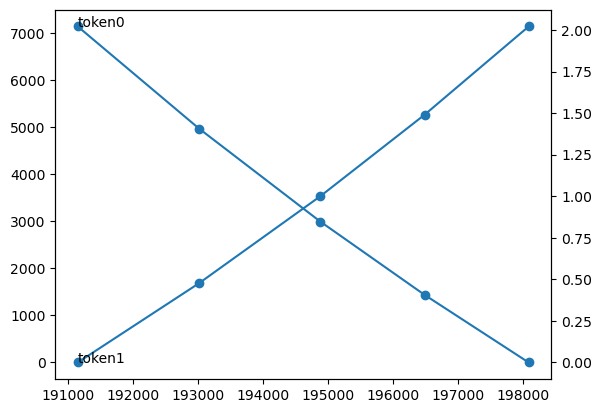

,ticks,amount0,amount1,prices
0,191150.0,7144.356303,0.000000,4998.918171
1,193014.0,4973.338583,0.476718,4148.848570
2,194878.0,2995.507735,1.000000,3443.333910
3,196479.0,1438.775789,1.489752,2934.239077
4,198080.0,0.000000,2.020983,2499.913599


In [19]:
liquidity = pool.functions.liquidity().call()

tick_bottom = 191150
tick_top = 198080

sa = tick_to_price(tick_bottom // 2)
sb = tick_to_price(tick_top // 2)

display(sa, sb)

ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

ticks = []
amount0 = []
amount1 = []
prices = []

for tick in [tick_bottom, (tick_bottom + current_tick) / 2,  current_tick, (current_tick + tick_top) / 2, tick_top]:
    sp = tick_to_price(tick // 2)
    
    in_tick_amount0 = int(liquidity * (1 / sp - 1 / sb))
    in_tick_amount1 = int(liquidity * (sp - sa))

    ticks.append(tick)
    amount0.append(token0.scaled(in_tick_amount0))
    amount1.append(token1.scaled(in_tick_amount1))
    prices.append(1 / (sp * sp * scale_multiplier))

    display((f'{sa=}, {sb=}, {sp=}, {liquidity=}', f'{in_tick_amount0=}', f'{in_tick_amount1=}'))
    test_1 = (in_tick_amount0 + liquidity / sb) * (in_tick_amount1 + liquidity * sa)
    test_2 = (liquidity * liquidity)
    display(('Test equality:', tick, test_1 / test_2 - 1, test_1 - test_2) )

ax.scatter(ticks, amount0)
ax.plot(ticks, amount0)
ax.text(ticks[0], amount0[0], 'token0')
ax2.scatter(ticks, amount1)
ax2.plot(ticks, amount1)
ax2.text(ticks[0], amount1[0], 'token1')

plt.show()

pd.DataFrame({'ticks': ticks, 'amount0': amount0, 'amount1': amount1, 'prices': prices})


### Full tick spacing liquidity


{191150: 345073104699360, 198080: -345073104699360}

2024684.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 2351651526716180.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 2995507735, 2995507575.0, 160.0),
 ('token1 balance: ', 9.999999998703532e+17, 999999999871526563, -1173376.0))

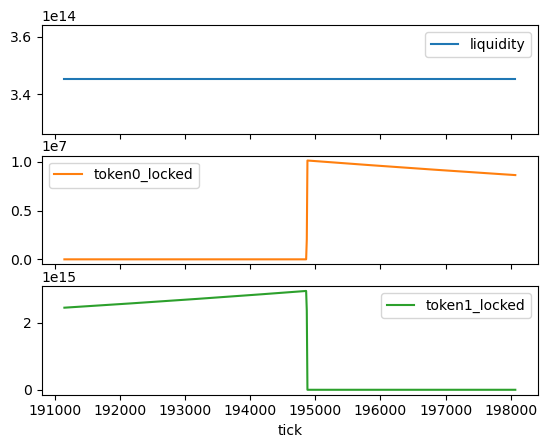

In [20]:
pool_min_tick = 191150
pool_max_tick = 198080

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)

df_pool = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool.token0_locked.sum(), token0_bal - df_pool.token0_locked.sum()),
    ('token1 balance: ', df_pool.token1_locked.sum(), token1_bal, df_pool.token1_locked.sum() - token1_bal),
))

df_pool.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

In [21]:
display(pool.functions.slot0().call()[1])
df_pool.loc[df_pool.tick.isin([194850, 194860,194870,194880,194890]),:]

194878

,tick,token0,token1,liquidity,token0_locked,token1_locked,token0_scaled,token1_scaled,token0_prop,token1_prop,token0_locked_scaled,token1_locked_scaled,token0_locked_prop,token1_locked_prop
370,194850,10135574.0,2.936773e+15,345073104699360,0.0,2.936773e+15,10.135574,0.002937,0.003384,0.002937,0.000000,0.002937,0.000000,0.002937
371,194860,10130508.0,2.938242e+15,345073104699360,0.0,2.938242e+15,10.130508,0.002938,0.003382,0.002938,0.000000,0.002938,0.000000,0.002938
372,194870,2024684.0,2.351652e+15,345073104699360,2024684.0,2.351652e+15,2.024684,0.002352,0.000676,0.002352,2.024684,0.002352,0.000676,0.002352
373,194880,10120383.0,2.941182e+15,345073104699360,10120383.0,0.000000e+00,10.120383,0.002941,0.003379,0.002941,10.120383,0.000000,0.003379,0.000000
374,194890,10115325.0,2.942652e+15,345073104699360,10115325.0,0.000000e+00,10.115325,0.002943,0.003377,0.002943,10.115325,0.000000,0.003377,0.000000


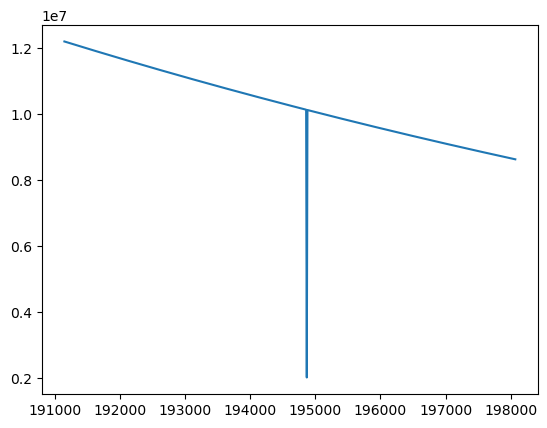

In [22]:
plt.plot(df_pool.tick, df_pool.token0); plt.show()

### 2. After first swap


In [23]:
param = {'chain_id': 1,
 'block_number': 12376891,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context3, model_loader3 = %cmf param
context3.set_current()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal))

(2875763641, 1034999999871526563)


In [24]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context3.block_number')
df_mint_burn_swap_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,evt_type,inp_liquidity,inp_tick,inp_recipient,liquidity,pool_liquidity,current_tick,token0_bal,token1_bal
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint,<NA>,<NA>,NaN,345073104699360,345073104699360,194878,2995507735,999999999871526563
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,<NA>,<NA>,0,-119744094,35000000000000000,swap,345073104699360,194996,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,345073104699360,194996,2875763641,1034999999871526563


{191150: 345073104699360, 198080: -345073104699360}

4025347.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 1774263639383149.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 2875763641, 2876396955.0, -633314.0),
 ('token1 balance: ',
  1.0347963405215876e+18,
  1034999999871526563,
  -203659349938944.0))

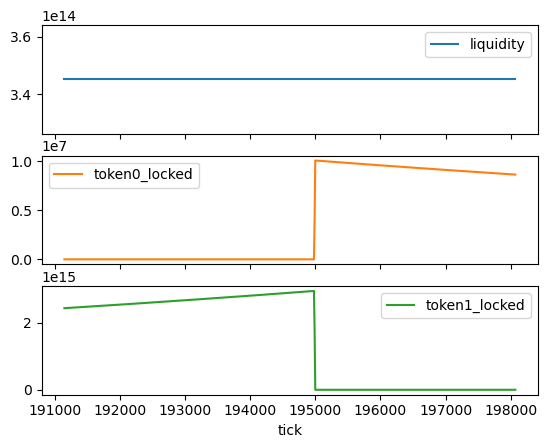

In [25]:
pool_min_tick = df_mint_burn_swap_sel.inp_tickLower.min()
pool_max_tick = df_mint_burn_swap_sel.inp_tickUpper.max()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

### After mint and burn


In [26]:
param = {'chain_id': 1,
 'block_number': 12377266,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context4, model_loader4 = %cmf param
context4.set_current()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity))

(887046094, 2703643983514648010, 508154610607382)


In [27]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context4.block_number')
print(df_mint_burn_swap_sel.liquidity.to_list()[-1])
df_mint_burn_swap_sel

508154610607382


,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,evt_type,inp_liquidity,inp_tick,inp_recipient,liquidity,pool_liquidity,current_tick,token0_bal,token1_bal
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint,<NA>,<NA>,NaN,345073104699360,345073104699360,194878,2995507735,999999999871526563
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,<NA>,<NA>,0,-119744094,35000000000000000,swap,345073104699360,194996,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,345073104699360,194996,2875763641,1034999999871526563
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373906,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531,mint,<NA>,<NA>,NaN,60160016191517,60160016191517,194996,288576365,103643987668006189
5,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,447994594415865,598469729,2599999995846641821,mint,<NA>,<NA>,NaN,508154610607382,508154610607382,194996,887046094,2703643983514648010


{194990: 25652705721581,
 191150: 34507310469936,
 186730: 447994594415865,
 195010: -25652705721581,
 195460: -447994594415865,
 198080: -34507310469936}

5927725.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 2612780412345051.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 887046094, 887978784.0, -932690.0),
 ('token1 balance: ',
  2.7033698452779704e+18,
  2703643983514648010,
  -274138236677632.0))

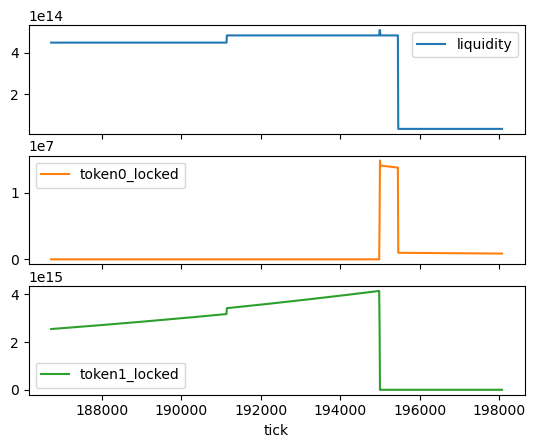

In [29]:
pool_min_tick = df_mint_burn_swap_sel.inp_tickLower.min()
pool_max_tick = df_mint_burn_swap_sel.inp_tickUpper.max()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

In [30]:
param = {'chain_id': 1,
 'block_number': 12377278,
 'model_loader_path': [],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context5, model_loader5 = %cmf param
context5.set_current()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity, current_tick))

(1386802508, 2559402919199232831, 482501904885801, 194645)


In [31]:
df_mint_burn_swap_sel = df_mint_burn_swap.query('evt_block_number <= @context5.block_number')
df_mint_burn_swap_sel

,evt_block_number,evt_index,evt_tx_hash,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,evt_type,inp_liquidity,inp_tick,inp_recipient,liquidity,pool_liquidity,current_tick,token0_bal,token1_bal
0,12376729,106,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint,<NA>,<NA>,NaN,345073104699360,345073104699360,194878,2995507735,999999999871526563
1,12376891,73,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,NaN,<NA>,<NA>,0,-119744094,35000000000000000,swap,345073104699360,194996,0xE592427A0AEce92De3Edee1F18E0157C05861564,345073104699360,345073104699360,194996,2875763641,1034999999871526563
2,12376958,122,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,-2588187276,-931484249884373906,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
3,12376958,124,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0,burn,<NA>,<NA>,NaN,34507310469936,34507310469936,194996,287576365,103498249987152658
4,12377035,195,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531,mint,<NA>,<NA>,NaN,60160016191517,60160016191517,194996,288576365,103643987668006189
5,12377266,286,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,447994594415865,598469729,2599999995846641821,mint,<NA>,<NA>,NaN,508154610607382,508154610607382,194996,887046094,2703643983514648010
6,12377278,240,0x53d4bc1240410e1c7907b8049f2355e226f5fcae8c16...,NaN,<NA>,<NA>,-25652705721581,499756414,-144241064315415179,swap,482501904885801,194645,0xE592427A0AEce92De3Edee1F18E0157C05861564,482501904885801,482501904885801,194645,1386802508,2559402919199232831


{191150: 34507310469936,
 186730: 447994594415865,
 194990: 25652705721581,
 195010: -25652705721581,
 195460: -447994594415865,
 198080: -34507310469936}

7159981.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 2031487697404532.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 1386802508, 1386736038.0, 66470.0),
 ('token1 balance: ',
  2.5593508305806525e+18,
  2559402919199232831,
  -52088618580480.0))

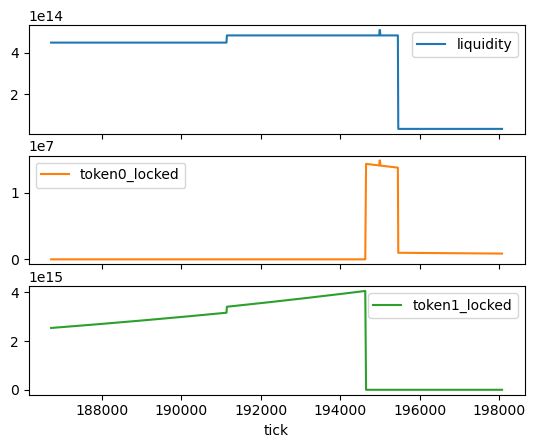

In [32]:
pool_min_tick = df_mint_burn_swap_sel.inp_tickLower.min()
pool_max_tick = df_mint_burn_swap_sel.inp_tickUpper.max()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

display(tick_mapping)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

In [33]:
param = {'chain_id': 1,
 'block_number': 15269596,
 'model_loader_path': ['../../credmark-models-py/models'],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context6, model_loader6 = %cmf param
context6.set_current()

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

current_liquidity = pool.functions.liquidity().call()
tick_spacing = pool.functions.tickSpacing().call()

slot0 = pool.functions.slot0().call()
current_sqrtPriceX96 = slot0[0]
current_tick = slot0[1]
current_price = tick_to_price(current_tick)

token0_addr = pool.functions.token0().call()
token1_addr = pool.functions.token1().call()
token0 = Token(address=Address(token0_addr).checksum)
token1 = Token(address=Address(token1_addr).checksum)
token0_bal = token0.balance_of(pool.address.checksum)
token1_bal = token1.balance_of(pool.address.checksum)

print((token0_bal, token1_bal, current_liquidity, current_tick))

(91279879131171, 59875596839944146417511, 16110902232733136438, 202180)


In [37]:
pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

pool_min_tick = min(df_burn_min_max.lower_min.min(), df_mint_min_max.lower_min.min())
pool_max_tick = max(df_burn_min_max.upper_max.max(), df_mint_min_max.upper_max.max())

liquidity_by_ticks = context.run_model('uniswap-v3.get-liquidity-by-ticks', 
                                      {"address": "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
                                      "min_tick": pool_min_tick,
                                      "max_tick": pool_max_tick})

liquidity_by_ticks.keys()


dict_keys(['liquidity', 'change_on_tick', 'liquidity_pos_on_tick', 'current_tick', 'current_liquidity', 'tick_spacing'])

-58324910837.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and -14365897014179635200.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 91279879131171, -55332129193290.0, 146612008324461.0),
 ('token1 balance: ',
  -6.5355284854763e+20,
  59875596839944146417511,
  -6.052914968849178e+22))

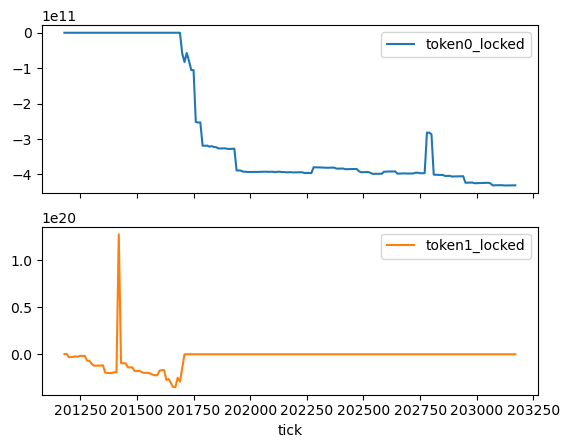

In [40]:
pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping_1k = get_liquidity_in_ticks(pool, current_tick-1000, current_tick+1000)

df_pool_1k = get_amount_in_ticks(pool, token0, token1, tick_mapping_1k)

display((
    ('token0 balance: ', token0_bal, df_pool_1k.token0_locked.sum(), token0_bal - df_pool_1k.token0_locked.sum()),
    ('token1 balance: ', df_pool_1k.token1_locked.sum(), token1_bal, df_pool_1k.token1_locked.sum() - token1_bal),
))

df_pool_1k.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

# assert df_pool_1k.liquidity[df_pool_1k.liquidity < 0].shape[0] == 0
# df_pool_1k.liquidity[df_pool_1k.liquidity < 0].shape[0]

In [41]:
list(tick_mapping_1k.items())[:10]

[(201700, -1563348795614860861),
 (201690, -345448666214750071),
 (201680, 830793168310438582),
 (201670, -847073670039563),
 (201660, -367819622729685519),
 (201650, -345924888135483506),
 (201640, 87008550017433060),
 (201630, -879750309119075980),
 (201620, 3516011242817790),
 (201610, 43814653120352817)]

In [44]:
pool_min_tick = min(df_burn_min_max.lower_min.min(), df_mint_min_max.lower_min.min())
pool_max_tick = max(df_burn_min_max.upper_max.max(), df_mint_min_max.upper_max.max())

liquidity_by_ticks = context.run_model('uniswap-v3.get-liquidity-by-ticks', 
                                      {"address": "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
                                      "min_tick": pool_min_tick,
                                      "max_tick": pool_max_tick})

liquidity_by_ticks.keys()


dict_keys(['liquidity', 'change_on_tick', 'liquidity_pos_on_tick', 'current_tick', 'current_liquidity', 'tick_spacing'])

389449790722.00 address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48' and 95924631609560645632.00 address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2' remaining in the current tick range


(('token0 balance: ', 91279879131171, 73431005111662.0, 17848874019509.0),
 ('token1 balance: ',
  9.85562892199684e+22,
  59875596839944146417511,
  3.868069238002425e+22))

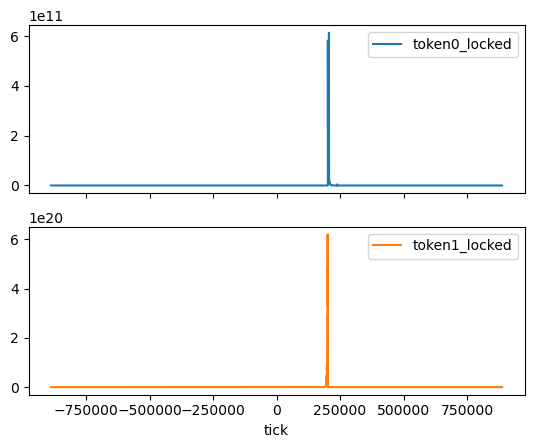

In [45]:
pool_min_tick = min(df_burn_min_max.lower_min.min(), df_mint_min_max.lower_min.min())
pool_max_tick = max(df_burn_min_max.upper_max.max(), df_mint_min_max.upper_max.max())

pool = load_univ3_pool('0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')
 
tick_mapping = get_liquidity_in_ticks(pool, pool_min_tick, pool_max_tick)

df_pool2 = get_amount_in_ticks(pool, token0, token1, tick_mapping)

assert df_pool2.liquidity[df_pool2.liquidity < 0].shape[0] == 0

display((
    ('token0 balance: ', token0_bal, df_pool2.token0_locked.sum(), token0_bal - df_pool2.token0_locked.sum()),
    ('token1 balance: ', df_pool2.token1_locked.sum(), token1_bal, df_pool2.token1_locked.sum() - token1_bal),
))

df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked', 'token1_locked'], sharex=True, subplots=True, kind='line')
plt.show()

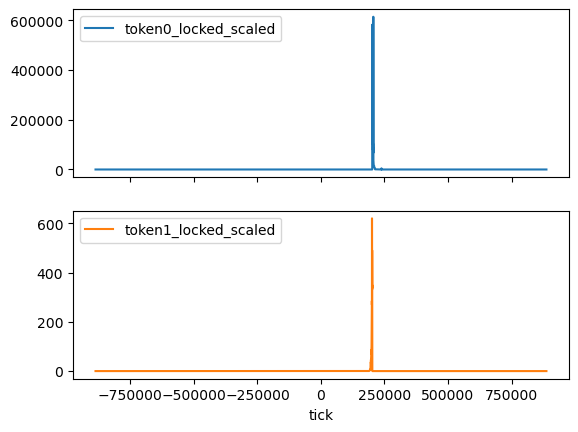

In [46]:
df_pool2.plot(x = 'tick', y = ['liquidity', 'token0_locked_scaled', 'token1_locked_scaled'], sharex=True, subplots=True, kind='line')
plt.show()

In [47]:
df_pool2.token1_locked_scaled.sum(), token1.scaled(token1_bal)

(98556.2892199684, 59875.59683994415)

In [52]:
df_pool2.liquidity

0         2715994952501851
1         2715994952501851
2         2715994952501851
3         2715994952501851
4         2715994952501851
                ...       
177449    2625300554324117
177450    2625300554324117
177451    2625300554324117
177452    2625300554324117
177453    2625300554324117
Name: liquidity, Length: 177454, dtype: object

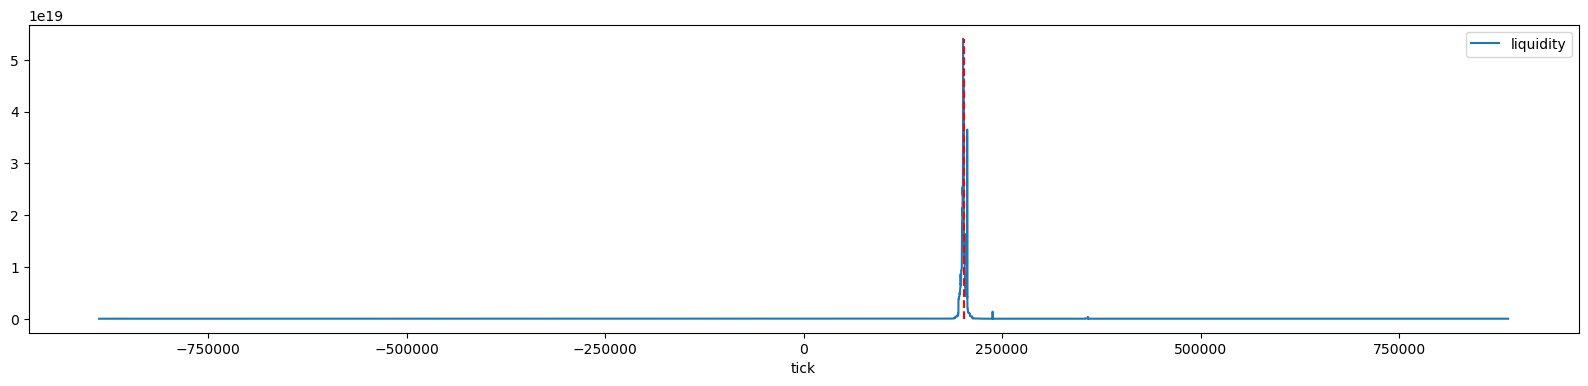

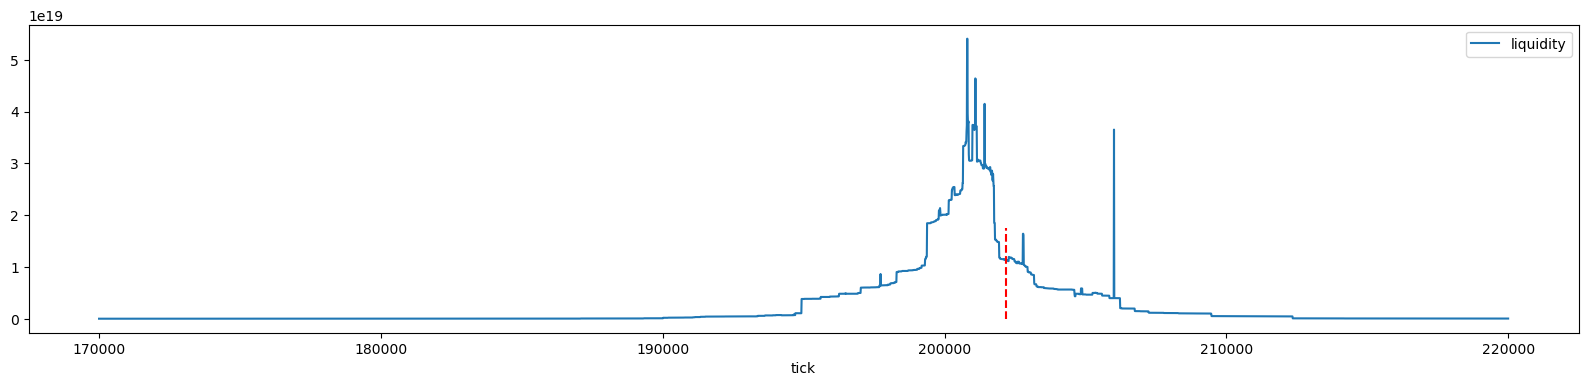

In [55]:
df_pool2 = df_pool2.assign(liquidity = lambda x: x.liquidity.astype('float'))

df_pool2.plot(x = 'tick', y = ['liquidity'], figsize=(20,4))
plt.vlines(x=current_tick, ymin=0, ymax=df_pool2.liquidity.max(), linestyles='dashed', colors='red')
plt.show()

df_pool2.query('(tick > 170000) & (tick < 220000)').plot(x = 'tick', y = ['liquidity'], figsize=(20,4))
plt.vlines(x=current_tick, ymin=0, ymax=1.75e19, linestyles='dashed', colors='red')
plt.show()

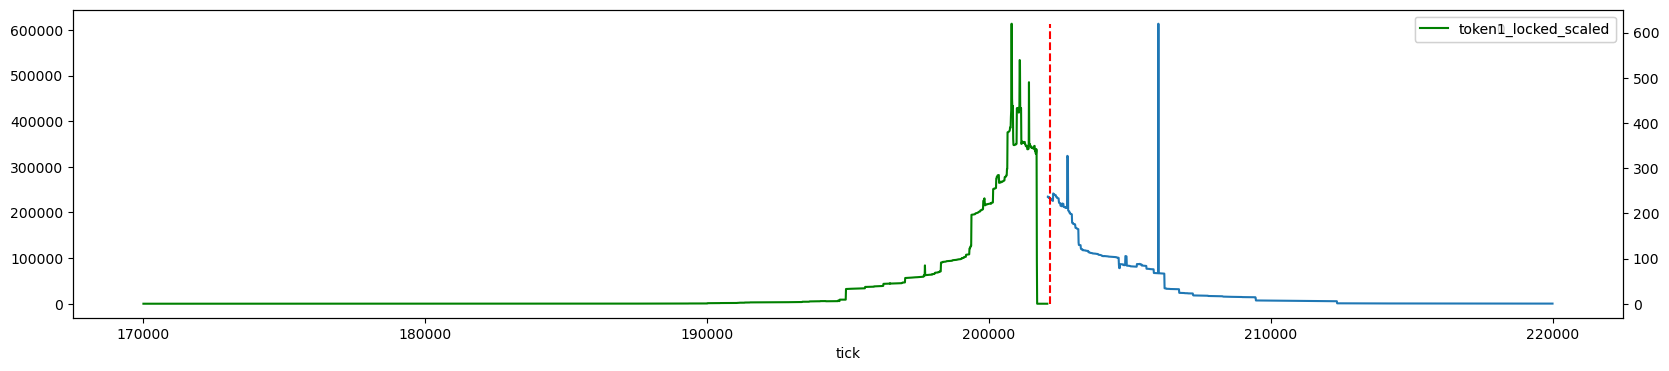

In [56]:
ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

df_pool2.query('(tick > @current_tick-@tick_spacing*10) & (tick < 220000)').plot(x = 'tick', y = ['token0_locked_scaled'], figsize=(20,4), ax=ax)
df_pool2.query('(tick < @current_tick-@tick_spacing*10) & (tick > 170000)').plot(x = 'tick', y = ['token1_locked_scaled'], figsize=(20,4), ax=ax2, color='green')
ax.vlines(x=current_tick, ymin=0, ymax=df_pool2.token0_locked_scaled.max(), linestyles='dashed', colors='red')
plt.show()

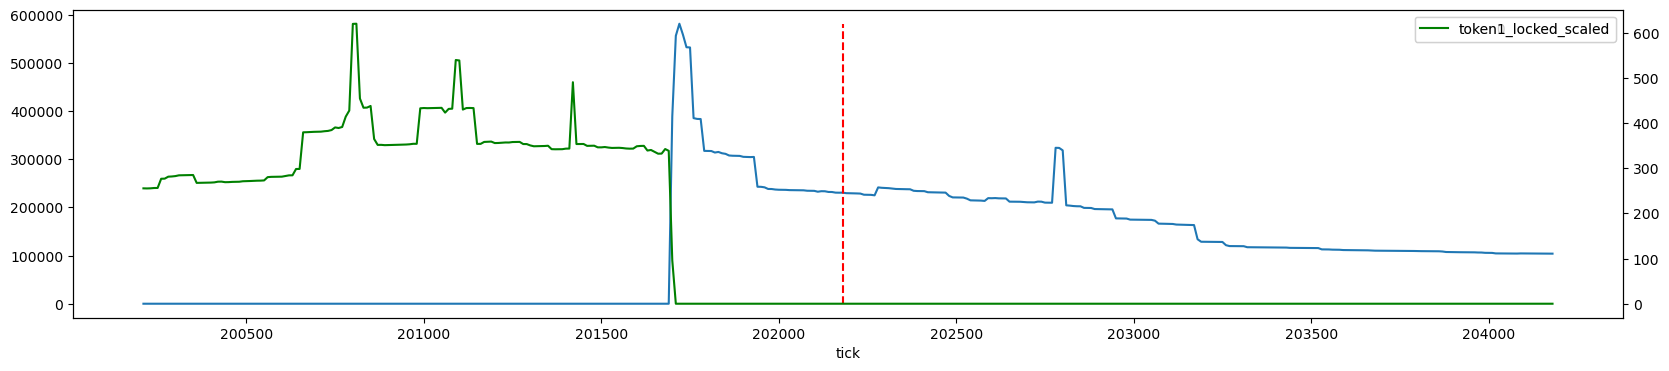

In [57]:
pa = 2022
pb = 1358

p_a = (1 / pa / scale_multiplier)
p_b = (1 / pb / scale_multiplier)

tick_a = math.log(p_a) / math.log(1.0001)
tick_b = math.log(p_b) / math.log(1.0001)

ax = plt.gca()    # Get current axis
ax2 = ax.twinx()  # make twin axis based on x

df_pool2_sel = df_pool2.query('(tick > @tick_a) & (tick < @tick_b)')
df_pool2_sel

df_pool2_sel.plot(x = 'tick', y = ['token0_locked_scaled'], figsize=(20,4), ax=ax)
df_pool2_sel.plot(x = 'tick', y = ['token1_locked_scaled'], figsize=(20,4), ax=ax2, color='green')
ax.vlines(x=current_tick, ymin=0, ymax=df_pool2_sel.token0_locked_scaled.max(), linestyles='dashed', colors='red')
plt.show()

On block 15269596

![UniswapV3 USDC-WETH-POOL](pool_liquidity_usdc_weth.png)


In [58]:
df_pool2.query('(tick > @tick_a) & (tick < @tick_b)')

,tick,token0,token1,liquidity,token0_locked,token1_locked,token0_scaled,token1_scaled,token0_prop,token1_prop,token0_locked_scaled,token1_locked_scaled,token0_locked_prop,token1_locked_prop
108748,200210,5.156309e+11,2.553472e+20,2.295021e+19,0.000000e+00,2.553472e+20,515630.853201,255.347219,0.006891,0.00257,0.000000,255.347219,0.000000,0.00257
108749,200220,5.147346e+11,2.551584e+20,2.292178e+19,0.000000e+00,2.551584e+20,514734.634970,255.158418,0.006879,0.002568,0.000000,255.158418,0.000000,0.002568
108750,200230,5.147459e+11,2.554193e+20,2.293374e+19,0.000000e+00,2.554193e+20,514745.851236,255.419257,0.006879,0.002571,0.000000,255.419257,0.000000,0.002571
108751,200240,5.156052e+11,2.561016e+20,2.298352e+19,0.000000e+00,2.561016e+20,515605.177707,256.101620,0.006890,0.002577,0.000000,256.101620,0.000000,0.002577
108752,200250,5.153679e+11,2.562398e+20,2.298443e+19,0.000000e+00,2.562398e+20,515367.862769,256.239844,0.006887,0.002579,0.000000,256.239844,0.000000,0.002579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109141,204140,1.042602e+11,7.648563e+19,5.648080e+18,1.042602e+11,0.000000e+00,104260.163530,76.485628,0.001393,0.00077,104260.163530,0.000000,0.001393,0.0
109142,204150,1.042080e+11,7.652388e+19,5.648080e+18,1.042080e+11,0.000000e+00,104208.049083,76.523878,0.001393,0.00077,104208.049083,0.000000,0.001393,0.0
109143,204160,1.041560e+11,7.656216e+19,5.648080e+18,1.041560e+11,0.000000e+00,104155.970410,76.562155,0.001392,0.000771,104155.970410,0.000000,0.001392,0.0
109144,204170,1.041054e+11,7.660154e+19,5.648161e+18,1.041054e+11,0.000000e+00,104105.403494,76.601544,0.001391,0.000771,104105.403494,0.000000,0.001391,0.0
